In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [92]:
#import some libraries
#pytorch
import torch as t
import torch.nn as nn
#用于*随机*分割数据集
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

**Pre-process the data**

In [93]:
#读入数据
data = pd.read_csv(r"/kaggle/input/digit-recognizer/train.csv",dtype = np.float32)
#分割为特征和标签
data_labels = data.label.values
data_features = data.loc[:,data.columns != "label"]
#归一化(均值呢?)
#避免梯度爆炸，方便训练，方便学习率的选取
data_features = data_features.values/255

#训练集和交叉验证集8:2
X_train,X_val,y_train,y_val = train_test_split(data_features,data_labels,test_size = 0.2,random_state = 0)

#转化为pytorch的tensor
X_train = t.from_numpy(X_train)
X_val = t.from_numpy(X_val)
y_train = t.from_numpy(y_train)
y_val = t.from_numpy(y_val)

#转化为pytorch的*数据集*
train = t.utils.data.TensorDataset(X_train,y_train)
test = t.utils.data.TensorDataset(X_val,y_val)

#设置超参数
#待调参

#批大小
#batch_size太小，下降方向不准确，模型不易收敛，损失会出现大幅震荡
batch_size = 100
#总迭代次数
iterations = 2500
#训练批次
epochs = int(iterations/(len(X_train)/batch_size))
#学习率
learning_rate = 0.1

#设置pytorch的*数据加载器*以用于训练
train_loader = t.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
#test数据集为什么也要用batch_size?
test_loader = t.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


**Build our model**

In [94]:
#创建类
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        
        #卷积层1
        #参数待调整
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        #池化层1
        #参数待调整
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #卷积层2
        #参数待调整
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        #池化层2
        #参数待调整
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #全连接层
        self.fc = nn.Linear(32*4*4,10)
        
    def forward(self, x):
        #卷积层1&池化层1
        out = self.maxpool1(self.relu1(self.cnn1(x)))
        
        #卷积层2&池化层2
        out = self.maxpool2(self.relu2(self.cnn2(out)))
        
        #将矩阵展成向量
        out = out.view(out.size(0), -1)
        
        #全连接层
        out = self.fc(out)
        
        return out
    
    

*Create our model and others*

In [95]:
# Create CNN model
model = CNNModel()

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# Optimizer
#尝试带有动量的SGD
#尝试学习率衰减的有动量的SGD
optimizer = t.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
#尝试ADAM
#未调参，效果差
#optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

#自定义学习率衰减函数
def lr_decay(optimizer, decay_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

***Train our model***

In [96]:
# initial some varibles
count = 0
loss_list = []
iteration_list = []
accuracy_list = []


# train our model
for epoch in range(epochs):
    #学习率衰减
    lr_decay(optimizer, 0.95)
    for i, (images, labels) in enumerate(train_loader):
        
        train = images.view(batch_size,1,28,28)
        labels = labels.long()
        
        #为什么清除梯度?
        #因为该函数是累计梯度的，每次训练新一批数据要将梯度清0
        optimizer.zero_grad()
        
        #前向传播
        outputs = model(train)
        
        #计算交叉熵损失
        loss = error(outputs, labels)
        
        #计算梯度
        loss.backward()
        
        #更新参数
        optimizer.step()
        count += 1
        if count % 50 == 0:
            #计算准确率
            correct = 0
            total = 0
            
            #计算在验证集上的准确率
            for images, labels in test_loader:
                
                #test = tensor(images.view(50,1,28,28))
                test = images.view(batch_size,1,28,28)
                #前向传播
                outputs = model(test)
                
                #得到预测的结果
                predicted = t.max(outputs.data, 1)[1]
                
                predicted = predicted.long()
                labels = labels.long()
                #标签总数量
                total += len(labels)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            #记录损失和迭代次数
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 100 == 0:
                print('Iteration:{} Loss:{} Accuracy:{}%'.format(count,loss.data,accuracy))
                

Iteration:100 Loss:0.18333031237125397 Accuracy:95%
Iteration:200 Loss:0.08430127799510956 Accuracy:97%
Iteration:300 Loss:0.0731169804930687 Accuracy:96%
Iteration:400 Loss:0.07121673226356506 Accuracy:97%
Iteration:500 Loss:0.00637831212952733 Accuracy:97%
Iteration:600 Loss:0.029406128451228142 Accuracy:98%
Iteration:700 Loss:0.1195763424038887 Accuracy:98%
Iteration:800 Loss:0.05459414795041084 Accuracy:98%
Iteration:900 Loss:0.02711385302245617 Accuracy:98%
Iteration:1000 Loss:0.026501379907131195 Accuracy:98%
Iteration:1100 Loss:0.1248568519949913 Accuracy:98%
Iteration:1200 Loss:0.0757884830236435 Accuracy:98%
Iteration:1300 Loss:0.03185306489467621 Accuracy:98%
Iteration:1400 Loss:0.0059311725199222565 Accuracy:98%
Iteration:1500 Loss:0.0074420832097530365 Accuracy:98%
Iteration:1600 Loss:0.07193280756473541 Accuracy:98%
Iteration:1700 Loss:0.006653766613453627 Accuracy:98%
Iteration:1800 Loss:0.009276480413973331 Accuracy:98%
Iteration:1900 Loss:0.04981449991464615 Accuracy:98

***Visualization loss and accuracy***

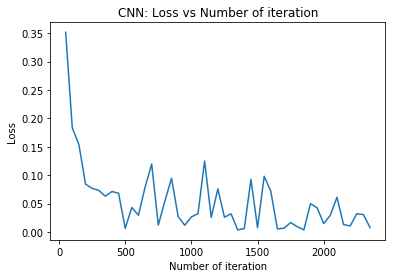

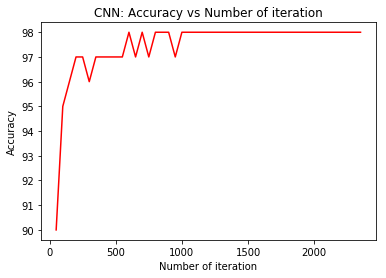

In [97]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()